In [ ]:

import os
os.makedirs('/content/Processed', exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'\ndevice: {device}')

Cloning into 'Low-Medical-Imaging'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 141 (delta 67), reused 111 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 4.60 MiB | 26.63 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/Low-Medical-Imaging/Low-Medical-Imaging/Low-Medical-Imaging
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

device: cuda


In [4]:
import os
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from PIL import Image

class ChestXrayDataset(Dataset):

    def __init__(self,
                 dataset_root: str,
                 split: str = "train",
                 image_size: Tuple[int, int] = (448, 448),
                 augment: bool = True,
                 normalize: bool = True,
                 augmentation_strength: float = 0.5):
        self.dataset_root = dataset_root
        self.split = split
        self.image_size = image_size
        self.augment = augment
        self.normalize = normalize
        self.augmentation_strength = augmentation_strength

        self.label_map = {"NORMAL": 0, "PNEUMONIA": 1}
        self.images = []
        self.labels = []

        self._load_image_paths()

        # Define augmentation and normalization pipelines
        self.augmentation_transforms = self._get_augmentation_transforms()
        self.normalization_transforms = self._get_normalization_transforms()

    def _load_image_paths(self):
        """Load all image paths from the dataset directory."""
        split_dir = os.path.join(self.dataset_root, self.split)

        if not os.path.exists(split_dir):
            raise ValueError(f"Split directory {split_dir} does not exist.")

        for label, label_idx in self.label_map.items():
            label_dir = os.path.join(split_dir, label)

            if not os.path.exists(label_dir):
                print(f"Warning: Label directory {label_dir} does not exist. Skipping.")
                continue

            for img_name in os.listdir(label_dir):
                if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(label_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(label_idx)

        if len(self.images) == 0:
            raise ValueError(f"No images found in {split_dir}")

        print(f"Loaded {len(self.images)} images from {self.split} split.")

    def _get_augmentation_transforms(self) -> transforms.Compose:
        """Create augmentation transformations."""
        aug_list = [
            transforms.RandomRotation(degrees=20 * self.augmentation_strength),
            transforms.RandomAffine(degrees=0, translate=(0.1 * self.augmentation_strength, 0.1 * self.augmentation_strength)),
            transforms.RandomHorizontalFlip(p=0.5 * self.augmentation_strength),
        ]

        return transforms.Compose(aug_list)

    def _get_normalization_transforms(self) -> transforms.Compose:
        """Create normalization transformations using ImageNet stats."""
        return transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self) -> int:
        """Return the total number of images in the dataset."""
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load grayscale image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")

        # Resize to target size
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        # Convert to RGB (stack grayscale into 3 channels)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        # Convert to PIL Image for torchvision transforms
        img_pil = Image.fromarray(img_rgb)
        # Convert to tensor and normalize to [0, 1]
        img_tensor = transforms.ToTensor()(img_pil)
        # Apply augmentation if training
        if self.augment and self.split == "train":
            img_tensor = self.augmentation_transforms(img_tensor)

        # Clip values to [0, 1] after augmentation
        img_tensor = torch.clamp(img_tensor, 0, 1)
        # Apply normalization
        if self.normalize:
            img_tensor = self.normalization_transforms(img_tensor)

        return img_tensor, label

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
from PIL import Image
from typing import List

class CustomImageDataset(Dataset):

    def __init__(self,
                 images: List[str],
                 labels: List[int],
                 augment: bool = False,
                 normalize: bool = True,
                 image_size: tuple = (448, 448),
                 augmentation_strength: float = 0.5):

        self.images = images
        self.labels = labels
        self.augment = augment
        self.normalize = normalize
        self.image_size = image_size
        self.augmentation_strength = augmentation_strength
        self.augmentation_transforms = self._get_augmentation_transforms()
        self.normalization_transforms = self._get_normalization_transforms()

    def _get_augmentation_transforms(self):
        aug_list = [
            transforms.RandomRotation(degrees=20 * self.augmentation_strength),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1 * self.augmentation_strength, 0.1 * self.augmentation_strength)
            ),
            transforms.RandomHorizontalFlip(p=0.5 * self.augmentation_strength),
        ]
        return transforms.Compose(aug_list)

    def _get_normalization_transforms(self):
        return transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tensor = transforms.ToTensor()(img_pil)
        if self.augment:
            img_tensor = self.augmentation_transforms(img_tensor)
        img_tensor = torch.clamp(img_tensor, 0, 1)
        if self.normalize:
            img_tensor = self.normalization_transforms(img_tensor)

        return img_tensor, label

In [6]:
Data_Root = Path('/content/drive/MyDrive/chest_xray')
data_full_train = ChestXrayDataset(Data_Root,split="train",
    augment=False,
    normalize=False )
SUBSET_JSON = "/content/Processed/subset_indices_300.json"
SUBSET_SIZE = 300
SEED = 42

Loaded 5216 images from train split.


In [7]:
print(data_full_train)
img, label = data_full_train[0]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Image dtype: {img.dtype}")

Image shape: torch.Size([3, 448, 448])
Label: 0
Image dtype: torch.float32


In [8]:
'''Creating subset of 300 images for Pheumonia detection task'''
import json
from pathlib import Path
from typing import Optional, List, Dict
import numpy as np
from collections import defaultdict
from torch.utils.data import Subset

def _rng(seed: int):
    """Return a numpy Generator for reproducible sampling."""
    return np.random.default_rng(seed)

def create_subset_indices(
    dataset,
    subset_size: Optional[int] = None,
    per_class: Optional[int] = None,
    seed: int = 42,
    save_path: str = "data/processed/subset_indices.json",
    patient_col: Optional[str] = None
) -> Dict:
    rng = _rng(seed)

    # Validate dataset exposes labels
    if not hasattr(dataset, "labels"):
        raise ValueError("Dataset must expose `labels` (list or array) in the same order as indexing.")

    labels_arr = np.array(dataset.labels)
    unique_classes = np.unique(labels_arr).tolist()
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    '''This block samples patients instead of images to avoid data leakage. It requires a patient identifier column
    in the dataset's dataframe (dataset.df) to group images'''
    if patient_col and hasattr(dataset, "df") and patient_col in dataset.df.columns:
        # build patient -> list(indices) mapping and patient -> class mapping (dominant label)
        patient_to_indices = defaultdict(list)
        for idx, pid in enumerate(dataset.df[patient_col].values):
            patient_to_indices[pid].append(idx)

        # map patient -> class (majority class of that patient's images)
        patient_to_class = {}
        for pid, inds in patient_to_indices.items():
            labs = labels_arr[inds]
            # majority label for patient
            vals, counts = np.unique(labs, return_counts=True)
            patient_to_class[pid] = int(vals[np.argmax(counts)])

        # Prepare per-class list of patients
        class_to_patients = defaultdict(list)
        for pid, cls in patient_to_class.items():
            class_to_patients[int(cls)].append(pid)

        indices_selected = []

        if per_class is not None:
            # select patients per class until we have enough images or hit patient count
            for cls in unique_classes:
                pats = class_to_patients[int(cls)]
                rng.shuffle(pats)
                sel_pats = []
                img_count = 0
                for p in pats:
                    sel_pats.append(p)
                    img_count += len(patient_to_indices[p])
                    if img_count >= per_class:
                        break
                # expand to indices
                for p in sel_pats:
                    indices_selected.extend(patient_to_indices[p])
        else:
            # sample patients (balanced across classes proportionally) until >= subset_size images
            # flatten a patient list with class labels to sample from
            all_patients = list(patient_to_indices.keys())
            rng.shuffle(all_patients)
            selected_patients = []
            total_images = 0
            # simple greedy collect until reaching subset_size
            for p in all_patients:
                selected_patients.append(p)
                total_images += len(patient_to_indices[p])
                if subset_size is not None and total_images >= subset_size:
                    break
            for p in selected_patients:
                indices_selected.extend(patient_to_indices[p])

        indices = np.array(sorted(set(indices_selected)), dtype=int)

    else:

        class_indices = {int(c): np.where(labels_arr == c)[0] for c in unique_classes}

        if per_class is not None:
            # sample exactly per_class from each class (if available)
            indices = []
            for cls, inds in class_indices.items():
                if len(inds) < per_class:
                    raise ValueError(f"Not enough samples in class {cls}: requested {per_class}, available {len(inds)}")
                sel = rng.choice(inds, size=per_class, replace=False)
                indices.append(sel)
            indices = np.concatenate(indices)
        else:
            # stratified sampling proportional to class frequencies
            if subset_size is None:
                raise ValueError("Either subset_size or per_class must be provided.")
            # compute class quotas (rounding: last class gets remainder)
            counts = {cls: len(inds) for cls, inds in class_indices.items()}
            total_available = sum(counts.values())
            proportions = {cls: counts[cls] / total_available for cls in counts}
            indices = []
            remaining = subset_size
            classes = list(class_indices.keys())
            for i, cls in enumerate(classes):
                if i == len(classes) - 1:
                    k = remaining
                else:
                    k = int(round(proportions[cls] * subset_size))
                    remaining -= k
                k = min(k, len(class_indices[cls]))
                sel = rng.choice(class_indices[cls], size=k, replace=False)
                indices.append(sel)
            indices = np.concatenate(indices)
    # final shuffle of indices
    indices = np.array(indices, dtype=int)
    rng.shuffle(indices)

    info = {
        "indices": indices.tolist(),
        "subset_size": len(indices),
        "seed": int(seed),
        "per_class": int(per_class) if per_class is not None else None,
        "patient_level": bool(patient_col is not None and hasattr(dataset, "df") and patient_col in dataset.df.columns),
    }
    # compute class counts
    unique, counts = np.unique(labels_arr[indices], return_counts=True)
    info["class_counts"] = {int(u): int(c) for u, c in zip(unique.tolist(), counts.tolist())}

    with open(save_path, "w") as f:
        json.dump(info, f, indent=2)

    print(f"[subset_utils] Saved subset indices ({info['subset_size']}) to {save_path}")
    return info


def load_subset(dataset, indices_path: str = "data/processed/subset_indices.json"):
    path = Path(indices_path)
    if not path.exists():
        raise FileNotFoundError(f"Subset indices JSON not found: {path}")
    with open(path, "r") as f:
        info = json.load(f)
    indices = info["indices"]
    print(f"[subset_utils] Loaded {len(indices)} indices from {indices_path}")
    return Subset(dataset, indices) # return a Subset object

In [9]:
info = create_subset_indices(
    dataset= data_full_train,
    subset_size=SUBSET_SIZE,
    seed=SEED,
    save_path=SUBSET_JSON,
    patient_col=None   # or "patient_id" if your dataset exposes a patient column
)
print("Created subset JSON files:", info)
print("Class counts in subset:", info["class_counts"])

[subset_utils] Saved subset indices (300) to /content/Processed/subset_indices_300.json
Created subset JSON files: {'indices': [1205, 549, 829, 4999, 1653, 3863, 3010, 671, 3003, 2598, 556, 2318, 4481, 1699, 626, 830, 3976, 4842, 1497, 479, 3549, 5153, 1006, 2221, 2000, 705, 915, 5026, 1222, 82, 4957, 5192, 3690, 1974, 4566, 4001, 2955, 5066, 1874, 657, 2543, 3135, 4822, 4115, 3320, 990, 2567, 1671, 3161, 3528, 1244, 4703, 2309, 3961, 2565, 4354, 2985, 1982, 5165, 2352, 2047, 637, 2036, 1664, 583, 1925, 3778, 1284, 2647, 88, 983, 1754, 5208, 5201, 3435, 1424, 4127, 4933, 3395, 3184, 1090, 3193, 3730, 3379, 2722, 2326, 4697, 2421, 2919, 3408, 3568, 999, 2353, 5075, 463, 3035, 360, 164, 3886, 1730, 4537, 1933, 1912, 1271, 4276, 3648, 722, 5035, 2013, 2491, 109, 3405, 4401, 2494, 2899, 1022, 2594, 1378, 493, 3009, 1171, 3905, 546, 2839, 3994, 4774, 5211, 3900, 4077, 1193, 3526, 5069, 1729, 1513, 2557, 1657, 4324, 203, 4899, 3024, 253, 2639, 3173, 3104, 1116, 3378, 5166, 2518, 919, 3197, 1

# Model (Transfer Learning)

In [10]:
import os
import time
import csv
from pathlib import Path
from typing import Optional, Dict, Tuple, List
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast

# optional metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
try:
    from sklearn.metrics import roc_auc_score
    _HAS_AUC = True
except Exception:
    _HAS_AUC = False

class ModelBTrainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        train_loader,
        val_loader,
        test_loader = None,
        save_dir: str = "experiments",
        experiment_name: str = "run",
        use_amp: bool = True,
        clip_grad_norm: Optional[float] = 1.0,
        monitor: str = "val_auc",   # "val_auc" | "val_loss" | "val_acc"
        log_interval: int = 50,
        save_interval: int = 10,
    ):
        self.model = model
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.use_amp = use_amp
        self.scaler = GradScaler(enabled=use_amp)
        self.clip_grad_norm = clip_grad_norm
        # logging & saving
        self.base_dir = Path(save_dir) / experiment_name
        self.base_dir.mkdir(parents=True, exist_ok=True)
        self.checkpoint_dir = self.base_dir / "checkpoints"
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.best_model_path =  self.base_dir / "best_model.pth"
        self.csv_log = self.base_dir / "training_log.csv"

        # training state
        self.monitor = monitor
        self.best_metric = -float("inf") if monitor != "val_loss" else float("inf")
        self.best_epoch = None
        self.no_improve_epochs = 0
        self.log_interval = log_interval
        self.save_interval = save_interval

          # history dict
        self.history: Dict[str, List] = {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [], "val_precision": [],
            "val_recall": [], "val_f1": [], "val_auc": [],
            "lrs": [], "epoch_time_s": []
        }

        # move model to device
        self.model.to(self.device)

        # initialize CSV header
        if not self.csv_log.exists():
            with open(self.csv_log, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "epoch", "train_loss", "train_acc",
                    "val_loss", "val_acc", "val_precision", "val_recall", "val_f1", "val_auc",
                    "lr", "epoch_time_s"
                ])

    def train_epoch(self, criterion, optimizer, epoch: int, num_epochs: int) -> Tuple[float, float, List[int], List[int]]:
        self.model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        scaler = self.scaler

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=120)
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            optimizer.zero_grad()
            if self.use_amp:
                with autocast():
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                if self.clip_grad_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                if self.clip_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

            avg_loss = running_loss / (batch_idx + 1)
            current_acc = accuracy_score(all_labels, all_preds)
            if (batch_idx + 1) % self.log_interval == 0 or (batch_idx + 1) == len(self.train_loader):
                pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{current_acc:.4f}'})

        epoch_loss = running_loss / max(1, len(self.train_loader))
        epoch_acc = accuracy_score(all_labels, all_preds)
        return epoch_loss, epoch_acc, all_preds, all_labels

    def validate_epoch(self, criterion, epoch: int, num_epochs: int, loader=None) -> Tuple[float, float, float, float, float, List[int], List[int]]:

        if loader is None:
            loader = self.val_loader
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []  # for AUC if available

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False, ncols=120)
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(pbar):
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)

                if self.use_amp:
                    with autocast():
                        outputs = self.model(images)
                else:
                    outputs = self.model(images)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.detach().cpu().numpy().tolist())
                all_labels.extend(labels.detach().cpu().numpy().tolist())

                if _HAS_AUC and outputs.size(1) == 2:
                    all_probs.append(probs[:, 1].detach().cpu().numpy())

                avg_loss = running_loss / (batch_idx + 1)
                current_acc = accuracy_score(all_labels, all_preds)
                if (batch_idx + 1) % self.log_interval == 0 or (batch_idx + 1) == len(loader):
                    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{current_acc:.4f}'})

        val_loss = running_loss / max(1, len(loader))
        val_acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)

        val_auc = None
        if _HAS_AUC and len(all_probs) > 0:
            try:
                import numpy as _np
                y_score = _np.concatenate(all_probs, axis=0)
                y_true = _np.array(all_labels)
                val_auc = float(roc_auc_score(y_true, y_score))
            except Exception:
                val_auc = None

        return val_loss, val_acc, precision, recall, f1, val_auc, all_preds, all_labels


    def _is_better(self, metric_val: float) -> bool:
        """Return True if metric_val is an improvement per chosen monitor."""
        if self.monitor == "val_loss":
            return metric_val < self.best_metric
        else:
            return metric_val > self.best_metric

    def _update_best(self, metric_val: float, epoch: int):
        if self.best_epoch is None:
            # initialize best_metric properly
            self.best_metric = metric_val
            self.best_epoch = epoch
            return True
        better = (metric_val < self.best_metric) if (self.monitor == "val_loss") else (metric_val > self.best_metric)
        if better:
            self.best_metric = metric_val
            self.best_epoch = epoch
            return True
        return False

    def save_checkpoint(self, epoch: int, optimizer, scheduler=None, is_best: bool = False):
        path = self.checkpoint_dir / f"checkpoint_epoch_{epoch:03d}.pt"
        ck = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "best_metric": self.best_metric
        }
        if self.use_amp:
            ck["scaler_state_dict"] = self.scaler.state_dict()
        torch.save(ck, path)
        if is_best:
            torch.save(self.model.state_dict(), self.best_model_path)
        return path


    def fit(
        self,
        num_epochs: int,
        optimizer,
        criterion = None,
        scheduler = None,
        resume_checkpoint: Optional[str] = None,
        save_best_only: bool = True,
        verbose: bool = True
    ) -> Dict:

        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        start_epoch = 1
        # resume checkpoint if given
        if resume_checkpoint:
            ck = torch.load(resume_checkpoint, map_location=self.device)
            self.model.load_state_dict(ck["model_state_dict"])
            if "optimizer_state_dict" in ck and ck["optimizer_state_dict"] is not None:
                optimizer.load_state_dict(ck["optimizer_state_dict"])
            if scheduler is not None and "scheduler_state_dict" in ck and ck["scheduler_state_dict"] is not None:
                try:
                    scheduler.load_state_dict(ck["scheduler_state_dict"])
                except Exception:
                    pass
            if self.use_amp and "scaler_state_dict" in ck and ck["scaler_state_dict"] is not None:
                try:
                    self.scaler.load_state_dict(ck["scaler_state_dict"])
                except Exception:
                    pass
            start_epoch = ck.get("epoch", 0) + 1
            if verbose:
                print(f"[resume] loaded checkpoint {resume_checkpoint}, starting epoch {start_epoch}")

        if verbose:
            print("\n" + "="*80)
            print("Starting training (Model C)")
            print(f"Device: {self.device}")
            print(f"Train samples: {len(self.train_loader.dataset)}  Val samples: {len(self.val_loader.dataset)}")
            print(f"Batch size: {self.train_loader.batch_size}")
            print("="*80 + "\n")

        for epoch in range(start_epoch, num_epochs + 1):
            epoch_t0 = time.time()

            train_loss, train_acc, _, _ = self.train_epoch(criterion, optimizer, epoch-1, num_epochs)
            val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = self.validate_epoch(criterion, epoch-1, num_epochs)

            # scheduler step (handle ReduceLROnPlateau separately)
            if scheduler is not None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    # ReduceLROnPlateau expects a metric to monitor; using val_loss here
                    if self.monitor == "val_loss":
                        scheduler.step(val_loss)
                    else:
                        # if monitor is val_auc or val_acc, pass that metric (prefers val_auc)
                        metric_for_scheduler = val_auc if (val_auc is not None) else val_acc
                        scheduler.step(metric_for_scheduler)
                else:
                    try:
                        scheduler.step()
                    except Exception:
                        pass

            epoch_time = time.time() - epoch_t0
            current_lr = optimizer.param_groups[0]["lr"]

            # record history
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["val_precision"].append(val_prec)
            self.history["val_recall"].append(val_rec)
            self.history["val_f1"].append(val_f1)
            self.history["val_auc"].append(val_auc if val_auc is not None else float("nan"))
            self.history["lrs"].append(current_lr)
            self.history["epoch_time_s"].append(epoch_time)

            # CSV logging
            with open(self.csv_log, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch, f"{train_loss:.6f}", f"{train_acc:.4f}",
                    f"{val_loss:.6f}", f"{val_acc:.4f}", f"{val_prec:.4f}",
                    f"{val_rec:.4f}", f"{val_f1:.4f}", f"{val_auc if val_auc is not None else 'nan'}",
                    f"{current_lr:.6e}", f"{epoch_time:.1f}"
                ])

            # print brief summary
            print(f"[Epoch {epoch}/{num_epochs}] train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
                  f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} val_auc={val_auc} lr={current_lr:.2e} time={epoch_time:.1f}s")

            # checkpointing
            if self.monitor == "val_loss":
                metric_val = val_loss
            elif self.monitor == "val_auc":
                metric_val = val_auc if val_auc is not None else val_acc
            else:
                metric_val = val_acc

            improved = False
            if self.best_epoch is None:
                self.best_epoch = epoch
                self.best_metric = metric_val
                improved = True
            else:
                # for val_loss lower is better, for others higher is better
                if self.monitor == "val_loss":
                    if metric_val < self.best_metric:
                        improved = True
                else:
                    if metric_val is not None and metric_val > self.best_metric:
                        improved = True

            if improved:
                self.best_metric = metric_val
                self.best_epoch = epoch
                self.save_checkpoint(epoch, optimizer, scheduler, is_best=True)
                self.no_improve_epochs = 0
                print(f"  ✓ New best model (epoch {epoch}) saved. {self.monitor} = {metric_val}")
            else:
                self.no_improve_epochs += 1
                if epoch % self.save_interval == 0:
                    self.save_checkpoint(epoch, optimizer, scheduler, is_best=False)


        if self.best_model_path.exists():
            self.model.load_state_dict(torch.load(self.best_model_path, map_location=self.device))
            if verbose:
                print(f"\n✓ Loaded best model from epoch {self.best_epoch}")
        # end epochs
        # load best model for final evaluation if exists
        test_results = None
        if self.test_loader is not None:
            test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, _, _ = self.validate_epoch(
                criterion, -1, num_epochs, loader=self.test_loader
            )

            test_results = {
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_precision": test_prec,
                "test_recall": test_rec,
                "test_f1": test_f1,
                "test_auc": test_auc
            }

            print(f"\n{'='*80}")
            print("FINAL TEST RESULTS")
            print(f"{'='*80}")
            print(f"  Loss:      {test_loss:.4f}")
            print(f"  Accuracy:  {test_acc:.4f}")
            print(f"  Precision: {test_prec:.4f}")
            print(f"  Recall:    {test_rec:.4f}")
            print(f"  F1-Score:  {test_f1:.4f}")
            print(f"  AUC:       {test_auc if test_auc is not None else 'N/A'}")
            print(f"{'='*80}")

        return {
            "history": self.history,
            "best_metric": self.best_metric,
            "best_epoch": self.best_epoch,
            "test_results": test_results,
        }


        return {
            "history": self.history,
            "best_metric": self.best_metric,
            "best_epoch": self.best_epoch,
            "test_results": test_results,
        }

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from typing import Optional
class ClassificationHead(nn.Module):
    """MLP classification head for feature vectors."""

    def __init__(self, input_dim: int, num_classes: int, dropout_rate: float = 0.3):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)


class DenseNet121Classifier(nn.Module):

    def __init__(
        self,
        num_classes: int = 2,
        dropout_rate: float = 0.3,
        pretrained: bool = True,
        freeze_backbone: bool = True,
    ):
        super().__init__()

        # Load pretrained DenseNet121
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.densenet121(weights=weights)

        # Get feature dimension
        self.feature_dim = self.backbone.classifier.in_features
        # Remove original classifier
        self.backbone.classifier = nn.Identity()

        # Freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone frozen (feature extraction mode)")

        # Add custom classification head
        self.classification_head = ClassificationHead(
            input_dim=self.feature_dim,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
        )

        self._print_param_info()

    def _print_param_info(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen = total - trainable

        print(f"\n{'='*60}")
        print("DenseNet121 Classifier")
        print(f"{'='*60}")
        print(f"Feature dimension: {self.feature_dim}")
        print(f"Total parameters: {total:,}")
        print(f"Trainable parameters: {trainable:,}")
        print(f"Frozen parameters: {frozen:,}")
        print(f"Trainable %: {100 * trainable / total:.2f}%")
        print(f"{'='*60}\n")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        logits = self.classification_head(features)
        return logits

    def unfreeze_backbone(self, unfreeze_layers: Optional[int] = None):

        if unfreeze_layers is None:
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("Entire backbone unfrozen")
        else:
            # DenseNet121 has 4 dense blocks
            dense_blocks = ["denseblock4", "denseblock3", "denseblock2", "denseblock1"]
            transitions = ["transition3", "transition2", "transition1"]

            blocks_to_unfreeze = dense_blocks[:unfreeze_layers]
            trans_to_unfreeze = transitions[:max(0, unfreeze_layers - 1)]

            for name, param in self.backbone.named_parameters():
                for block in blocks_to_unfreeze + trans_to_unfreeze:
                    if block in name:
                        param.requires_grad = True
                        break

            print(f"Unfroze last {unfreeze_layers} dense block(s)")

        self._print_param_info()


In [12]:
def train_with_kfold(Data_Root, SUBSET_JSON,BATCH_SIZE,
        NUM_WORKERS,NUM_EPOCHS,device,n_folds):
    with open(SUBSET_JSON, 'r') as f:
        subset_data = json.load(f)
        subset_indices = subset_data['indices']

    print(f"Loaded {len(subset_indices)} images for k-fold CV")
    #load full train dataset
    full_train_dataset = ChestXrayDataset(
        dataset_root=Data_Root,
        split="train",
        augment=False,
        normalize=True
    )
    # Load validation dataset
    val_dataset = ChestXrayDataset(
        dataset_root=Data_Root,
        split="val",
        augment=False,
        normalize=True
    )
    # Extract the 300 subset images and labels
    subset_images = [full_train_dataset.images[i] for i in subset_indices]
    subset_labels = [full_train_dataset.labels[i] for i in subset_indices]
    val_images = val_dataset.images
    val_labels = val_dataset.labels
    all_images = subset_images + val_images
    all_labels = subset_labels + val_labels

    print(f"Class distribution: Normal={subset_labels.count(0)}, Pneumonia={subset_labels.count(1)}")

    test_dataset = ChestXrayDataset(
        dataset_root=Data_Root,
        split="test",
        augment=False,
        normalize=True
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Initialize k-fold splitter (stratified to maintain class balance)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold_idx + 1}/{n_folds} - DenseNet-121 (Pretrained on ImageNet)")
        print(f"{'='*60}")
        print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")

        fold_train_images = [all_images[i] for i in train_idx]
        fold_train_labels = [all_labels[i] for i in train_idx]
        fold_val_images = [all_images[i] for i in val_idx]
        fold_val_labels = [all_labels[i] for i in val_idx]

        # Create custom datasets
        fold_train_dataset = CustomImageDataset(
            images=fold_train_images,
            labels=fold_train_labels,
            augment=True,
            normalize=True
        )
        fold_val_dataset = CustomImageDataset(
            images=fold_val_images,
            labels=fold_val_labels,
            augment=False,
            normalize=True
        )
        train_loader = DataLoader(
            fold_train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )

        val_loader = DataLoader(
            fold_val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


        #Model
        model = DenseNet121Classifier(
    num_classes=2,
    dropout_rate=0.3,  # ✓ Correct parameter name
    pretrained=True,
    freeze_backbone=True

    )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        trainer = ModelBTrainer(
            model=model,
            device=device,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            experiment_name="densenet_pneumonia_run1",
            use_amp=True,
            clip_grad_norm=1.0,
            log_interval=10,
            save_interval=10,
        )
        results = trainer.fit(num_epochs=20,
                              optimizer= torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3),
                              scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5, min_lr=1e-6, patience=4))

        fold_results.append({
    'fold': fold_idx + 1,
    'best_val_acc': results['best_metric'] * 100,
    'test_acc': results['test_results']['test_acc'] * 100,
    'test_auc': results['test_results']['test_auc']
})


    # Summary across all folds
    print(f"\n{'='*60}")
    print("K-FOLD CROSS-VALIDATION SUMMARY")
    print(f"{'='*60}")

    test_accs = [r['test_acc'] for r in fold_results]
    test_aucs = [r['test_auc'] for r in fold_results if r['test_auc'] is not None]

    print(f"\nTest Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    if test_aucs:
        print(f"Test AUC: {np.mean(test_aucs):.4f} ± {np.std(test_aucs):.4f}")

    print(f"\nDetailed Results:")
    for r in fold_results:
        print(f"  Fold {r['fold']}: Val={r['best_val_acc']:.2f}%, Test={r['test_acc']:.2f}%")


In [13]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# If scikit-learn is not installed, run this first:
!pip install -q scikit-learn

In [14]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
SUBSET_JSON = "/content/Processed/subset_indices_300.json"
BATCH_SIZE = 8
NUM_WORKERS = 2
NUM_EPOCHS = 20

fold_results = train_with_kfold(
        Data_Root=Data_Root,
        SUBSET_JSON=SUBSET_JSON,
        BATCH_SIZE=BATCH_SIZE,
        NUM_WORKERS=NUM_WORKERS,
        NUM_EPOCHS=NUM_EPOCHS,
        device=device,
        n_folds=5
    )

print("\n✓ K-Fold training completed successfully!")



Loaded 300 images for k-fold CV
Loaded 5216 images from train split.
Loaded 16 images from val split.
Class distribution: Normal=77, Pneumonia=223
Loaded 624 images from test split.

FOLD 1/5 - DenseNet-121 (Pretrained on ImageNet)
Train samples: 252, Val samples: 64
Train batches: 32, Val batches: 8
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 49.2MB/s]


Backbone frozen (feature extraction mode)

DenseNet121 Classifier
Feature dimension: 1024
Total parameters: 7,481,730
Trainable parameters: 527,874
Frozen parameters: 6,953,856
Trainable %: 7.06%


Starting training (Model C)
Device: cuda
Train samples: 252  Val samples: 64
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/20] train_loss=0.6246 train_acc=0.7183 val_loss=0.2442 val_acc=0.9219 val_f1=0.8936 val_auc=0.9637046307884856 lr=1.00e-03 time=59.1s
  ✓ New best model (epoch 1) saved. val_auc = 0.9637046307884856


Epoch 2/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/20] train_loss=0.3688 train_acc=0.8333 val_loss=0.3736 val_acc=0.8281 val_f1=0.8074 val_auc=0.981226533166458 lr=1.00e-03 time=13.4s
  ✓ New best model (epoch 2) saved. val_auc = 0.981226533166458


Epoch 3/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():
^^ ^ ^ 

[Epoch 3/20] train_loss=0.3326 train_acc=0.8452 val_loss=0.1902 val_acc=0.9375 val_f1=0.9129 val_auc=0.9887359198998749 lr=1.00e-03 time=14.9s
  ✓ New best model (epoch 3) saved. val_auc = 0.9887359198998749


Epoch 4/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/20] train_loss=0.4749 train_acc=0.8333 val_loss=0.3862 val_acc=0.8438 val_f1=0.8268 val_auc=0.9912390488110138 lr=1.00e-03 time=14.7s
  ✓ New best model (epoch 4) saved. val_auc = 0.9912390488110138


Epoch 5/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/20] train_loss=0.4645 train_acc=0.8611 val_loss=0.1993 val_acc=0.9062 val_f1=0.8877 val_auc=0.9937421777221527 lr=1.00e-03 time=14.2s
  ✓ New best model (epoch 5) saved. val_auc = 0.9937421777221527


Epoch 6/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
  ^ ^ ^ ^^ ^^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^ ^ 
   File "/usr/lib/py

Epoch 6/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/20] train_loss=0.2058 train_acc=0.9286 val_loss=0.2680 val_acc=0.9062 val_f1=0.8909 val_auc=0.9924906132665832 lr=1.00e-03 time=15.1s


Epoch 7/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/20] train_loss=0.3289 train_acc=0.8968 val_loss=0.1933 val_acc=0.9219 val_f1=0.9078 val_auc=0.9937421777221527 lr=1.00e-03 time=13.6s


Epoch 8/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/20] train_loss=0.2230 train_acc=0.9206 val_loss=0.1078 val_acc=0.9375 val_f1=0.9227 val_auc=0.9962453066332916 lr=1.00e-03 time=12.1s
  ✓ New best model (epoch 8) saved. val_auc = 0.9962453066332916


Epoch 9/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/20] train_loss=0.3746 train_acc=0.8651 val_loss=0.1424 val_acc=0.9219 val_f1=0.9050 val_auc=0.9949937421777222 lr=1.00e-03 time=13.0s


Epoch 10/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/20] train_loss=0.3848 train_acc=0.9008 val_loss=0.0981 val_acc=0.9531 val_f1=0.9410 val_auc=0.9949937421777222 lr=1.00e-03 time=13.6s


Epoch 11/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/20] train_loss=0.5034 train_acc=0.8452 val_loss=0.0937 val_acc=0.9688 val_f1=0.9599 val_auc=0.9949937421777222 lr=1.00e-03 time=13.5s


Epoch 12/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/20] train_loss=0.2605 train_acc=0.8849 val_loss=0.0943 val_acc=0.9375 val_f1=0.9227 val_auc=0.9949937421777222 lr=1.00e-03 time=14.0s


Epoch 13/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/20] train_loss=0.2529 train_acc=0.8968 val_loss=0.3176 val_acc=0.9062 val_f1=0.8909 val_auc=0.9937421777221527 lr=1.00e-03 time=16.6s


Epoch 14/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/20] train_loss=0.2906 train_acc=0.8968 val_loss=0.1421 val_acc=0.9219 val_f1=0.9050 val_auc=0.9949937421777222 lr=1.00e-03 time=13.0s


Epoch 15/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/20] train_loss=0.2950 train_acc=0.9206 val_loss=0.1237 val_acc=0.9375 val_f1=0.9227 val_auc=0.9949937421777222 lr=1.00e-03 time=13.4s


Epoch 16/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/20] train_loss=0.2936 train_acc=0.9206 val_loss=0.1285 val_acc=0.9375 val_f1=0.9227 val_auc=0.9949937421777222 lr=1.00e-03 time=15.2s


Epoch 17/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/20] train_loss=0.4219 train_acc=0.8571 val_loss=0.2393 val_acc=0.9219 val_f1=0.9078 val_auc=0.9949937421777222 lr=1.00e-03 time=13.7s


Epoch 18/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/20] train_loss=0.4132 train_acc=0.8849 val_loss=0.6199 val_acc=0.7656 val_f1=0.7520 val_auc=0.9937421777221527 lr=1.00e-03 time=13.7s


Epoch 19/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^
    assert self._parent_pid == os.getpid(), 'can only test a child process'           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 19/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/20] train_loss=0.3235 train_acc=0.8810 val_loss=0.2871 val_acc=0.9062 val_f1=0.8909 val_auc=0.9924906132665832 lr=1.00e-03 time=21.0s


Epoch 20/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/20] train_loss=0.4385 train_acc=0.8690 val_loss=0.1275 val_acc=0.9219 val_f1=0.9050 val_auc=0.9924906132665832 lr=1.00e-03 time=15.4s

✓ Loaded best model from epoch 8


Epoch 0/20 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.3096
  Accuracy:  0.8862
  Precision: 0.9004
  Recall:    0.8585
  F1-Score:  0.8728
  AUC:       0.9638834100372562

FOLD 2/5 - DenseNet-121 (Pretrained on ImageNet)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8
Backbone frozen (feature extraction mode)

DenseNet121 Classifier
Feature dimension: 1024
Total parameters: 7,481,730
Trainable parameters: 527,874
Frozen parameters: 6,953,856
Trainable %: 7.06%


Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/20] train_loss=0.6541 train_acc=0.6798 val_loss=0.2613 val_acc=0.8889 val_f1=0.8661 val_auc=0.9590792838874681 lr=1.00e-03 time=13.1s
  ✓ New best model (epoch 1) saved. val_auc = 0.9590792838874681


Epoch 2/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
 ^    ^if w.is_alive():^
^  ^ ^ ^   ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
  ^ ^ ^ 
    File "/usr/lib

Epoch 2/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/20] train_loss=0.4005 train_acc=0.8419 val_loss=0.3033 val_acc=0.9048 val_f1=0.8870 val_auc=0.9718670076726341 lr=1.00e-03 time=14.6s
  ✓ New best model (epoch 2) saved. val_auc = 0.9718670076726341


Epoch 3/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/20] train_loss=0.3681 train_acc=0.8735 val_loss=0.2433 val_acc=0.9206 val_f1=0.8974 val_auc=0.9731457800511509 lr=1.00e-03 time=14.5s
  ✓ New best model (epoch 3) saved. val_auc = 0.9731457800511509


Epoch 4/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/20] train_loss=0.4716 train_acc=0.8538 val_loss=0.3820 val_acc=0.9048 val_f1=0.8901 val_auc=0.9731457800511508 lr=1.00e-03 time=14.0s


Epoch 5/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/20] train_loss=0.6717 train_acc=0.7945 val_loss=0.2507 val_acc=0.9206 val_f1=0.8974 val_auc=0.9718670076726342 lr=1.00e-03 time=13.6s


Epoch 6/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/20] train_loss=0.6251 train_acc=0.7826 val_loss=0.3065 val_acc=0.9206 val_f1=0.9043 val_auc=0.9718670076726343 lr=1.00e-03 time=13.9s


Epoch 7/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/20] train_loss=0.3060 train_acc=0.8893 val_loss=0.2094 val_acc=0.9365 val_f1=0.9194 val_auc=0.9744245524296674 lr=1.00e-03 time=13.6s
  ✓ New best model (epoch 7) saved. val_auc = 0.9744245524296674


Epoch 8/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/20] train_loss=0.3507 train_acc=0.8458 val_loss=0.2157 val_acc=0.9365 val_f1=0.9194 val_auc=0.9731457800511508 lr=1.00e-03 time=13.6s


Epoch 9/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/20] train_loss=0.3167 train_acc=0.8735 val_loss=0.2455 val_acc=0.9365 val_f1=0.9222 val_auc=0.9757033248081841 lr=1.00e-03 time=14.0s
  ✓ New best model (epoch 9) saved. val_auc = 0.9757033248081841


Epoch 10/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/20] train_loss=0.2050 train_acc=0.9209 val_loss=0.2594 val_acc=0.9206 val_f1=0.9011 val_auc=0.9769820971867007 lr=1.00e-03 time=14.2s
  ✓ New best model (epoch 10) saved. val_auc = 0.9769820971867007


Epoch 11/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ 

Epoch 11/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/20] train_loss=0.1967 train_acc=0.9407 val_loss=0.2548 val_acc=0.9365 val_f1=0.9194 val_auc=0.9769820971867007 lr=1.00e-03 time=15.5s


Epoch 12/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/20] train_loss=0.3536 train_acc=0.8735 val_loss=0.3152 val_acc=0.9206 val_f1=0.9043 val_auc=0.9744245524296675 lr=1.00e-03 time=14.1s


Epoch 13/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/20] train_loss=0.2462 train_acc=0.8814 val_loss=0.2370 val_acc=0.9206 val_f1=0.9011 val_auc=0.9782608695652174 lr=1.00e-03 time=12.6s
  ✓ New best model (epoch 13) saved. val_auc = 0.9782608695652174


Epoch 14/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():
^ ^^^  ^^ ^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^  ^  ^   ^ ^ ^^^^^^^
^^  File

Epoch 14/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/20] train_loss=0.3601 train_acc=0.9012 val_loss=0.2802 val_acc=0.9206 val_f1=0.8974 val_auc=0.9776214833759591 lr=1.00e-03 time=18.9s


Epoch 15/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/20] train_loss=0.2800 train_acc=0.9130 val_loss=0.2332 val_acc=0.9206 val_f1=0.9011 val_auc=0.9782608695652174 lr=1.00e-03 time=15.2s


Epoch 16/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/20] train_loss=0.2655 train_acc=0.9249 val_loss=0.2681 val_acc=0.9365 val_f1=0.9194 val_auc=0.9782608695652174 lr=1.00e-03 time=12.6s


Epoch 17/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/20] train_loss=0.3385 train_acc=0.8775 val_loss=0.2508 val_acc=0.9365 val_f1=0.9222 val_auc=0.9782608695652174 lr=1.00e-03 time=15.3s


Epoch 18/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/20] train_loss=0.2599 train_acc=0.8775 val_loss=0.2381 val_acc=0.9206 val_f1=0.9011 val_auc=0.9769820971867008 lr=1.00e-03 time=14.0s


Epoch 19/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/20] train_loss=0.2104 train_acc=0.9091 val_loss=0.2863 val_acc=0.9365 val_f1=0.9222 val_auc=0.9782608695652174 lr=1.00e-03 time=14.6s


Epoch 20/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 20/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/20] train_loss=0.2467 train_acc=0.9051 val_loss=0.2137 val_acc=0.9206 val_f1=0.9011 val_auc=0.9782608695652173 lr=1.00e-03 time=23.8s

✓ Loaded best model from epoch 13


Epoch 0/20 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.4106
  Accuracy:  0.8702
  Precision: 0.8961
  Recall:    0.8338
  F1-Score:  0.8516
  AUC:       0.9630780188472496

FOLD 3/5 - DenseNet-121 (Pretrained on ImageNet)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8
Backbone frozen (feature extraction mode)

DenseNet121 Classifier
Feature dimension: 1024
Total parameters: 7,481,730
Trainable parameters: 527,874
Frozen parameters: 6,953,856
Trainable %: 7.06%


Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/20] train_loss=0.6707 train_acc=0.6640 val_loss=0.2128 val_acc=0.9048 val_f1=0.8870 val_auc=0.9884910485933504 lr=1.00e-03 time=15.3s
  ✓ New best model (epoch 1) saved. val_auc = 0.9884910485933504


Epoch 2/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/20] train_loss=0.3911 train_acc=0.8221 val_loss=0.1409 val_acc=0.9365 val_f1=0.9222 val_auc=0.9910485933503836 lr=1.00e-03 time=14.1s
  ✓ New best model (epoch 2) saved. val_auc = 0.9910485933503836


Epoch 3/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/20] train_loss=0.2785 train_acc=0.8893 val_loss=0.1584 val_acc=0.9365 val_f1=0.9222 val_auc=0.9910485933503836 lr=1.00e-03 time=13.6s


Epoch 4/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/20] train_loss=0.5002 train_acc=0.8538 val_loss=0.5276 val_acc=0.7937 val_f1=0.6286 val_auc=0.9667519181585678 lr=1.00e-03 time=13.7s


Epoch 5/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/20] train_loss=0.6235 train_acc=0.8300 val_loss=0.1179 val_acc=0.9524 val_f1=0.9407 val_auc=0.9936061381074168 lr=1.00e-03 time=13.5s
  ✓ New best model (epoch 5) saved. val_auc = 0.9936061381074168


Epoch 6/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/20] train_loss=0.2398 train_acc=0.8854 val_loss=0.1287 val_acc=0.9524 val_f1=0.9407 val_auc=0.9884910485933504 lr=1.00e-03 time=13.1s


Epoch 7/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/20] train_loss=0.4938 train_acc=0.8340 val_loss=0.2610 val_acc=0.9048 val_f1=0.8870 val_auc=0.9884910485933504 lr=1.00e-03 time=13.5s


Epoch 8/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/20] train_loss=0.3302 train_acc=0.9012 val_loss=0.1205 val_acc=0.9524 val_f1=0.9407 val_auc=0.9923273657289002 lr=1.00e-03 time=13.9s


Epoch 9/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() ^^^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():
^ ^^  ^ ^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^ ^  ^ ^ ^ ^^ 
  File "/usr/

Epoch 9/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/20] train_loss=0.3976 train_acc=0.8814 val_loss=0.2409 val_acc=0.9206 val_f1=0.9072 val_auc=0.9961636828644501 lr=1.00e-03 time=19.6s
  ✓ New best model (epoch 9) saved. val_auc = 0.9961636828644501


Epoch 10/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/20] train_loss=0.2593 train_acc=0.8972 val_loss=0.1009 val_acc=0.9683 val_f1=0.9597 val_auc=0.9936061381074169 lr=1.00e-03 time=14.4s


Epoch 11/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/20] train_loss=0.5904 train_acc=0.8182 val_loss=0.1070 val_acc=0.9524 val_f1=0.9407 val_auc=0.9961636828644501 lr=1.00e-03 time=12.6s


Epoch 12/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/20] train_loss=0.3735 train_acc=0.8617 val_loss=0.1243 val_acc=0.9524 val_f1=0.9407 val_auc=0.9936061381074168 lr=1.00e-03 time=13.5s


Epoch 13/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/20] train_loss=0.2385 train_acc=0.9091 val_loss=0.1031 val_acc=0.9683 val_f1=0.9597 val_auc=0.9948849104859334 lr=1.00e-03 time=13.6s


Epoch 14/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/20] train_loss=0.2366 train_acc=0.9209 val_loss=0.1445 val_acc=0.9524 val_f1=0.9407 val_auc=0.9923273657289002 lr=1.00e-03 time=13.7s


Epoch 15/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/20] train_loss=0.2513 train_acc=0.9170 val_loss=0.1897 val_acc=0.9365 val_f1=0.9222 val_auc=0.9923273657289002 lr=1.00e-03 time=14.2s


Epoch 16/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 16/20] train_loss=0.2958 train_acc=0.9130 val_loss=0.1374 val_acc=0.9683 val_f1=0.9581 val_auc=0.9936061381074168 lr=1.00e-03 time=17.4s


Epoch 17/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00

Epoch 17/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/20] train_loss=0.2409 train_acc=0.9170 val_loss=0.3031 val_acc=0.9048 val_f1=0.8901 val_auc=0.9948849104859334 lr=1.00e-03 time=26.8s


Epoch 18/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/20] train_loss=0.5879 train_acc=0.8182 val_loss=0.4682 val_acc=0.8889 val_f1=0.8735 val_auc=0.9936061381074168 lr=1.00e-03 time=16.4s


Epoch 19/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/20] train_loss=0.2949 train_acc=0.8933 val_loss=0.1414 val_acc=0.9524 val_f1=0.9407 val_auc=0.9961636828644501 lr=1.00e-03 time=14.3s


Epoch 20/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/20] train_loss=0.2644 train_acc=0.9130 val_loss=0.1157 val_acc=0.9524 val_f1=0.9407 val_auc=0.9948849104859335 lr=1.00e-03 time=15.4s

✓ Loaded best model from epoch 9


Epoch 0/20 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.2887
  Accuracy:  0.8926
  Precision: 0.8828
  Recall:    0.9013
  F1-Score:  0.8886
  AUC:       0.9639875082182774

FOLD 4/5 - DenseNet-121 (Pretrained on ImageNet)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8
Backbone frozen (feature extraction mode)

DenseNet121 Classifier
Feature dimension: 1024
Total parameters: 7,481,730
Trainable parameters: 527,874
Frozen parameters: 6,953,856
Trainable %: 7.06%


Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/20] train_loss=0.4677 train_acc=0.7945 val_loss=0.3955 val_acc=0.8413 val_f1=0.8254 val_auc=0.9654731457800511 lr=1.00e-03 time=13.6s
  ✓ New best model (epoch 1) saved. val_auc = 0.9654731457800511


Epoch 2/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/20] train_loss=0.6449 train_acc=0.7945 val_loss=0.2259 val_acc=0.9206 val_f1=0.8930 val_auc=0.9705882352941175 lr=1.00e-03 time=13.7s
  ✓ New best model (epoch 2) saved. val_auc = 0.9705882352941175


Epoch 3/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/20] train_loss=0.3647 train_acc=0.8735 val_loss=0.3569 val_acc=0.9048 val_f1=0.8622 val_auc=0.9725063938618925 lr=1.00e-03 time=13.0s
  ✓ New best model (epoch 3) saved. val_auc = 0.9725063938618925


Epoch 4/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/20] train_loss=0.4613 train_acc=0.8340 val_loss=0.7067 val_acc=0.8254 val_f1=0.7075 val_auc=0.9801790281329923 lr=1.00e-03 time=13.4s
  ✓ New best model (epoch 4) saved. val_auc = 0.9801790281329923


Epoch 5/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/20] train_loss=0.4114 train_acc=0.8656 val_loss=0.1674 val_acc=0.9206 val_f1=0.8930 val_auc=0.9878516624040921 lr=1.00e-03 time=13.9s
  ✓ New best model (epoch 5) saved. val_auc = 0.9878516624040921


Epoch 6/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/20] train_loss=0.3043 train_acc=0.9091 val_loss=0.1251 val_acc=0.9524 val_f1=0.9426 val_auc=0.9936061381074168 lr=1.00e-03 time=13.6s
  ✓ New best model (epoch 6) saved. val_auc = 0.9936061381074168


Epoch 7/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/20] train_loss=0.3124 train_acc=0.8854 val_loss=0.0976 val_acc=0.9524 val_f1=0.9407 val_auc=0.9923273657289002 lr=1.00e-03 time=13.8s


Epoch 8/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/20] train_loss=0.3838 train_acc=0.8696 val_loss=0.1241 val_acc=0.9365 val_f1=0.9194 val_auc=0.9884910485933504 lr=1.00e-03 time=13.5s


Epoch 9/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/20] train_loss=0.6539 train_acc=0.7945 val_loss=0.1258 val_acc=0.9365 val_f1=0.9125 val_auc=0.9923273657289002 lr=1.00e-03 time=12.8s


Epoch 10/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/20] train_loss=0.3521 train_acc=0.8854 val_loss=0.1604 val_acc=0.9365 val_f1=0.9125 val_auc=0.9910485933503836 lr=1.00e-03 time=13.1s


Epoch 11/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/20] train_loss=0.2743 train_acc=0.8972 val_loss=0.1192 val_acc=0.9206 val_f1=0.8974 val_auc=0.9897698209718669 lr=1.00e-03 time=13.7s


Epoch 12/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/20] train_loss=0.2885 train_acc=0.9130 val_loss=0.1170 val_acc=0.9524 val_f1=0.9384 val_auc=0.9910485933503836 lr=1.00e-03 time=13.8s


Epoch 13/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/20] train_loss=0.3158 train_acc=0.9051 val_loss=0.1413 val_acc=0.9365 val_f1=0.9162 val_auc=0.9910485933503836 lr=1.00e-03 time=14.0s


Epoch 14/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/20] train_loss=0.3091 train_acc=0.8933 val_loss=0.1157 val_acc=0.9365 val_f1=0.9194 val_auc=0.9910485933503836 lr=1.00e-03 time=12.7s


Epoch 15/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/20] train_loss=0.3202 train_acc=0.8854 val_loss=0.1131 val_acc=0.9524 val_f1=0.9407 val_auc=0.9910485933503836 lr=1.00e-03 time=13.2s


Epoch 16/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 16/20] train_loss=0.3576 train_acc=0.9012 val_loss=0.0965 val_acc=0.9365 val_f1=0.9194 val_auc=0.9923273657289002 lr=1.00e-03 time=17.4s


Epoch 17/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/20] train_loss=0.3578 train_acc=0.8617 val_loss=0.1609 val_acc=0.9365 val_f1=0.9125 val_auc=0.9923273657289002 lr=1.00e-03 time=16.8s


Epoch 18/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/20] train_loss=0.2909 train_acc=0.9170 val_loss=0.1196 val_acc=0.9524 val_f1=0.9426 val_auc=0.9936061381074168 lr=1.00e-03 time=15.6s


Epoch 19/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/20] train_loss=0.3515 train_acc=0.8775 val_loss=0.1951 val_acc=0.9206 val_f1=0.8880 val_auc=0.9936061381074168 lr=1.00e-03 time=13.8s


Epoch 20/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/20] train_loss=0.2812 train_acc=0.8814 val_loss=0.2200 val_acc=0.9206 val_f1=0.8880 val_auc=0.9948849104859334 lr=1.00e-03 time=14.1s
  ✓ New best model (epoch 20) saved. val_auc = 0.9948849104859334

✓ Loaded best model from epoch 20


Epoch 0/20 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.7303
  Accuracy:  0.7885
  Precision: 0.8611
  Recall:    0.7205
  F1-Score:  0.7342
  AUC:       0.9546351084812623

FOLD 5/5 - DenseNet-121 (Pretrained on ImageNet)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8
Backbone frozen (feature extraction mode)

DenseNet121 Classifier
Feature dimension: 1024
Total parameters: 7,481,730
Trainable parameters: 527,874
Frozen parameters: 6,953,856
Trainable %: 7.06%


Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/20] train_loss=0.5625 train_acc=0.7470 val_loss=0.2432 val_acc=0.9206 val_f1=0.9011 val_auc=0.9539641943734015 lr=1.00e-03 time=23.6s
  ✓ New best model (epoch 1) saved. val_auc = 0.9539641943734015


Epoch 2/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/20] train_loss=0.5434 train_acc=0.8221 val_loss=0.4546 val_acc=0.8730 val_f1=0.8571 val_auc=0.9654731457800512 lr=1.00e-03 time=14.3s
  ✓ New best model (epoch 2) saved. val_auc = 0.9654731457800512


Epoch 3/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/20] train_loss=0.3954 train_acc=0.8300 val_loss=0.2856 val_acc=0.8730 val_f1=0.8493 val_auc=0.969309462915601 lr=1.00e-03 time=13.4s
  ✓ New best model (epoch 3) saved. val_auc = 0.969309462915601


Epoch 4/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^^if w.is_alive():
^ ^ ^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^ ^ ^ ^ ^ ^ ^ 
   File "/usr/

Epoch 4/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/20] train_loss=0.3212 train_acc=0.9012 val_loss=0.2877 val_acc=0.8889 val_f1=0.8661 val_auc=0.9757033248081841 lr=1.00e-03 time=15.3s
  ✓ New best model (epoch 4) saved. val_auc = 0.9757033248081841


Epoch 5/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/20] train_loss=0.4102 train_acc=0.8814 val_loss=0.3452 val_acc=0.8889 val_f1=0.8700 val_auc=0.9705882352941175 lr=1.00e-03 time=13.4s


Epoch 6/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/20] train_loss=0.2638 train_acc=0.9051 val_loss=0.3410 val_acc=0.9048 val_f1=0.8833 val_auc=0.9744245524296675 lr=1.00e-03 time=14.3s


Epoch 7/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00> 
  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers()   
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():
 ^   ^   ^^^^^^^^^^^^^^^^^^^^

Epoch 7/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/20] train_loss=0.5838 train_acc=0.8498 val_loss=0.3063 val_acc=0.9206 val_f1=0.8974 val_auc=0.9814578005115089 lr=1.00e-03 time=21.0s
  ✓ New best model (epoch 7) saved. val_auc = 0.9814578005115089


Epoch 8/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/20] train_loss=0.2912 train_acc=0.8933 val_loss=0.3490 val_acc=0.8889 val_f1=0.8700 val_auc=0.9782608695652174 lr=1.00e-03 time=13.2s


Epoch 9/20 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/20 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/20] train_loss=0.2786 train_acc=0.8933 val_loss=0.4902 val_acc=0.8889 val_f1=0.8700 val_auc=0.9757033248081841 lr=1.00e-03 time=14.8s


Epoch 10/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    

Epoch 10/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/20] train_loss=0.3590 train_acc=0.8656 val_loss=0.4143 val_acc=0.8889 val_f1=0.8700 val_auc=0.9808184143222506 lr=1.00e-03 time=20.4s


Epoch 11/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/20] train_loss=0.2973 train_acc=0.8933 val_loss=0.3002 val_acc=0.8889 val_f1=0.8700 val_auc=0.9833759590792839 lr=1.00e-03 time=14.7s
  ✓ New best model (epoch 11) saved. val_auc = 0.9833759590792839


Epoch 12/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/20] train_loss=0.3357 train_acc=0.8775 val_loss=0.2547 val_acc=0.9365 val_f1=0.9222 val_auc=0.9808184143222506 lr=1.00e-03 time=13.8s


Epoch 13/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/20] train_loss=0.6105 train_acc=0.8735 val_loss=0.2697 val_acc=0.9206 val_f1=0.8930 val_auc=0.9782608695652173 lr=1.00e-03 time=13.1s


Epoch 14/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/20] train_loss=0.2568 train_acc=0.8893 val_loss=0.5723 val_acc=0.8889 val_f1=0.8735 val_auc=0.9782608695652174 lr=1.00e-03 time=12.7s


Epoch 15/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/20] train_loss=0.3277 train_acc=0.9051 val_loss=0.4231 val_acc=0.8889 val_f1=0.8700 val_auc=0.9757033248081841 lr=1.00e-03 time=14.2s


Epoch 16/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/20] train_loss=0.3604 train_acc=0.8656 val_loss=0.6983 val_acc=0.8571 val_f1=0.8411 val_auc=0.9757033248081841 lr=1.00e-03 time=14.0s


Epoch 17/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3c97f7ec00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 17/20] train_loss=0.2698 train_acc=0.9170 val_loss=0.7077 val_acc=0.8730 val_f1=0.8571 val_auc=0.9769820971867007 lr=1.00e-03 time=19.2s


Epoch 18/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/20] train_loss=0.3512 train_acc=0.9012 val_loss=0.4862 val_acc=0.8889 val_f1=0.8700 val_auc=0.9782608695652173 lr=1.00e-03 time=17.3s


Epoch 19/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/20] train_loss=0.2300 train_acc=0.9170 val_loss=0.4379 val_acc=0.8889 val_f1=0.8700 val_auc=0.9795396419437339 lr=1.00e-03 time=15.5s


Epoch 20/20 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/20] train_loss=0.4590 train_acc=0.8538 val_loss=0.4222 val_acc=0.8889 val_f1=0.8700 val_auc=0.9769820971867007 lr=1.00e-03 time=12.4s

✓ Loaded best model from epoch 11


Epoch 0/20 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.3069
  Accuracy:  0.8718
  Precision: 0.8799
  Recall:    0.8453
  F1-Score:  0.8574
  AUC:       0.9604207758053913

K-FOLD CROSS-VALIDATION SUMMARY

Test Accuracy: 86.19% ± 3.77%
Test AUC: 0.9612 ± 0.0035

Detailed Results:
  Fold 1: Val=99.62%, Test=88.62%
  Fold 2: Val=97.83%, Test=87.02%
  Fold 3: Val=99.62%, Test=89.26%
  Fold 4: Val=99.49%, Test=78.85%
  Fold 5: Val=98.34%, Test=87.18%

✓ K-Fold training completed successfully!


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

print("Loading training log...")
df = pd.read_csv('/content/Low-Medical-Imaging/Low-Medical-Imaging/Low-Medical-Imaging/experiments/densenet_pneumonia_run1/training_log.csv')
print(f"✓ Loaded {len(df)} total epochs")

Loading training log...
✓ Loaded 100 total epochs


In [18]:
# Split into 5 folds (20 epochs each)
epochs_per_fold = 20
n_folds = 5

fold_logs = {}
for fold in range(1, n_folds + 1):
    start_idx = (fold - 1) * epochs_per_fold
    end_idx = fold * epochs_per_fold
    fold_df = df.iloc[start_idx:end_idx].copy()
    fold_df['epoch'] = range(1, epochs_per_fold + 1)
    fold_logs[fold] = fold_df
    print(f"✓ Fold {fold}: epochs {start_idx+1}-{end_idx}")

✓ Fold 1: epochs 1-20
✓ Fold 2: epochs 21-40
✓ Fold 3: epochs 41-60
✓ Fold 4: epochs 61-80
✓ Fold 5: epochs 81-100


In [19]:
# Prepare data for plotting
max_epochs = epochs_per_fold
epochs_array = np.arange(1, max_epochs + 1)

# Collect data from all folds
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_aucs = []

for fold, fold_df in fold_logs.items():
    train_losses.append(fold_df['train_loss'].values)
    val_losses.append(fold_df['val_loss'].values)
    train_accs.append(fold_df['train_acc'].values)
    val_accs.append(fold_df['val_acc'].values)
    val_aucs.append(fold_df['val_auc'].values)

# Convert to numpy arrays
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
train_accs = np.array(train_accs)
val_accs = np.array(val_accs)
val_aucs = np.array(val_aucs)

# Compute mean and std
train_loss_mean = np.mean(train_losses, axis=0)
train_loss_std = np.std(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)
val_loss_std = np.std(val_losses, axis=0)

train_acc_mean = np.mean(train_accs, axis=0)
train_acc_std = np.std(train_accs, axis=0)
val_acc_mean = np.mean(val_accs, axis=0)
val_acc_std = np.std(val_accs, axis=0)

val_auc_mean = np.mean(val_aucs, axis=0)
val_auc_std = np.std(val_aucs, axis=0)

print("✓ Data prepared for plotting")

✓ Data prepared for plotting


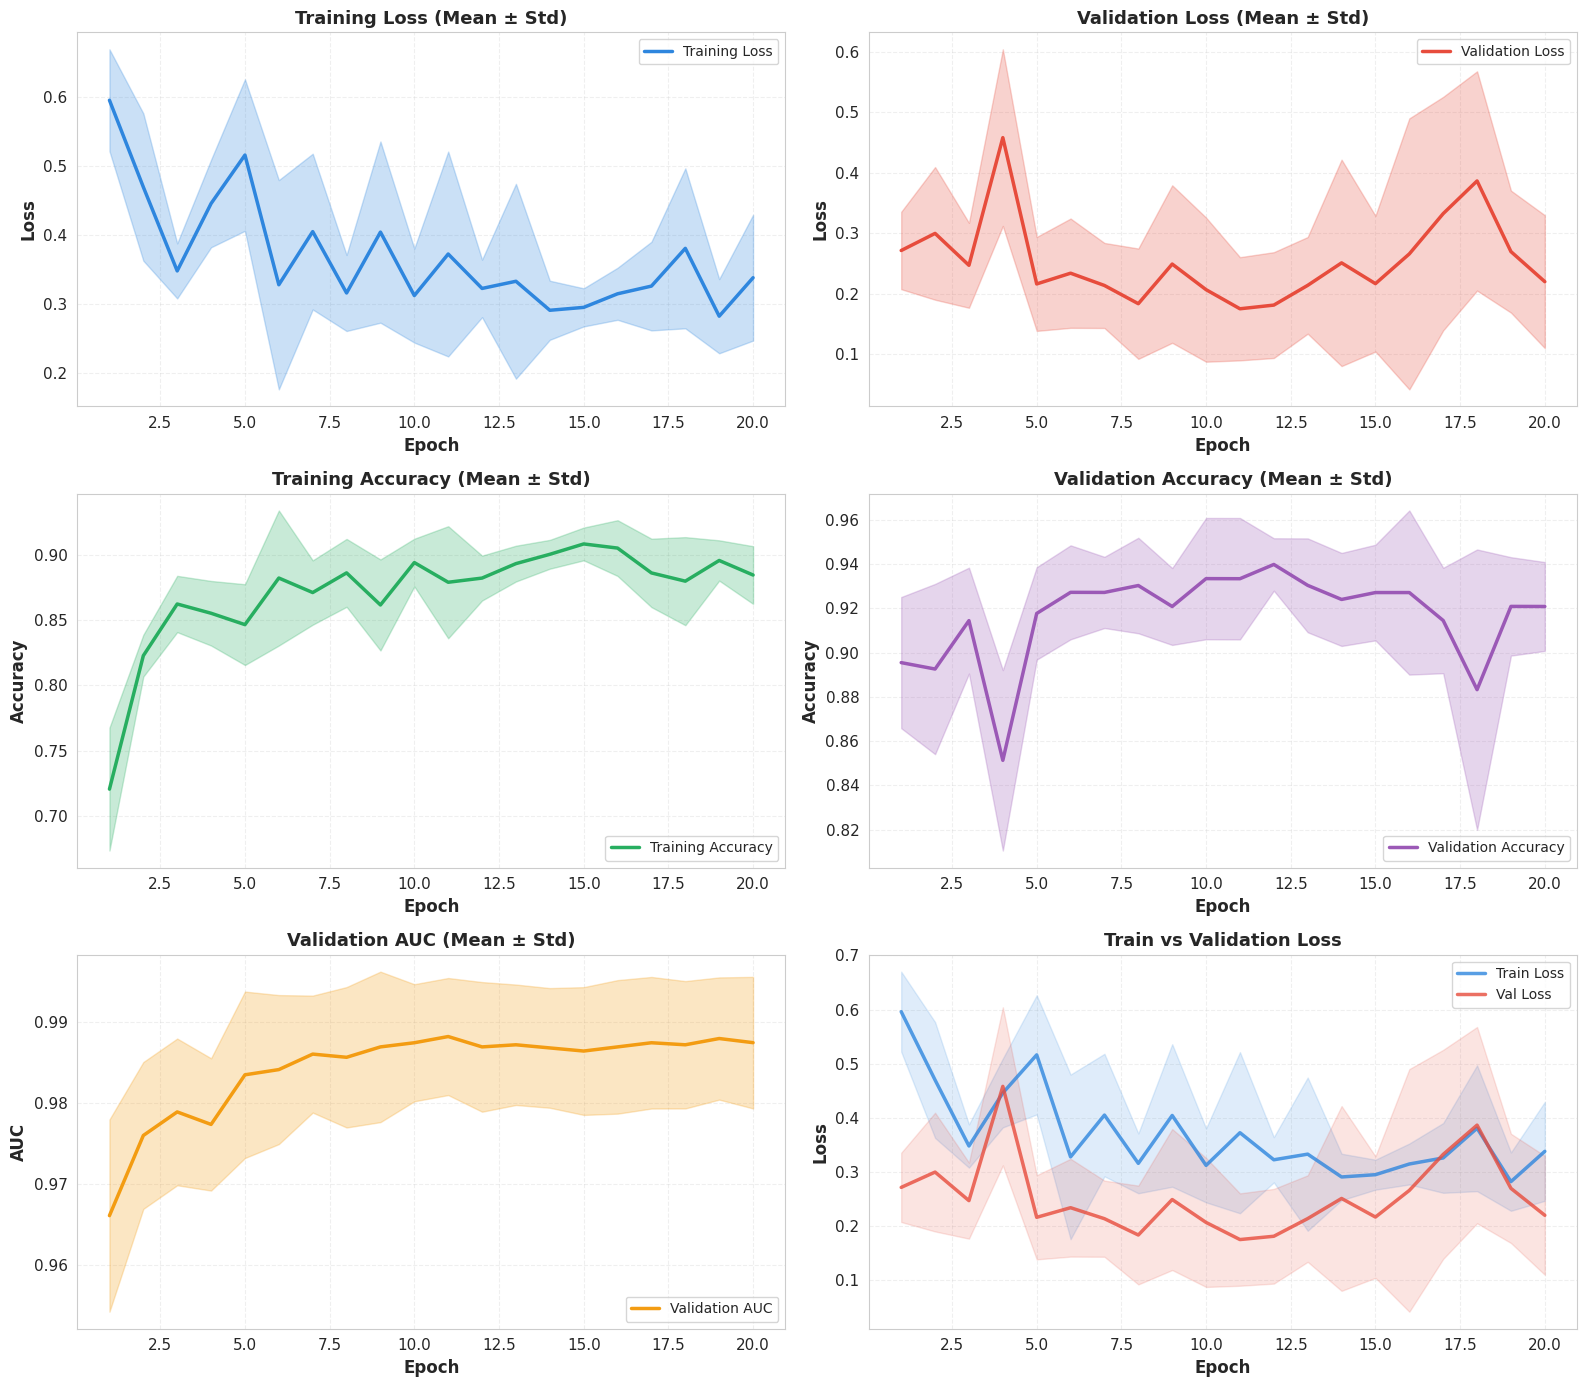


✅ Training curves plotted successfully!
📊 5-fold cross-validation: 5 folds × 20 epochs


In [20]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. TRAINING LOSS
ax = axes[0, 0]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE', label='Training Loss')
ax.fill_between(epochs_array, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.25, color='#2E86DE')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 2. VALIDATION LOSS
ax = axes[0, 1]
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#E74C3C', label='Validation Loss')
ax.fill_between(epochs_array, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.25, color='#E74C3C')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Validation Loss (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 3. TRAINING ACCURACY
ax = axes[1, 0]
ax.plot(epochs_array, train_acc_mean, linewidth=2.5, color='#27AE60', label='Training Accuracy')
ax.fill_between(epochs_array, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha=0.25, color='#27AE60')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Training Accuracy (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 4. VALIDATION ACCURACY
ax = axes[1, 1]
ax.plot(epochs_array, val_acc_mean, linewidth=2.5, color='#9B59B6', label='Validation Accuracy')
ax.fill_between(epochs_array, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha=0.25, color='#9B59B6')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Validation Accuracy (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 5. VALIDATION AUC
ax = axes[2, 0]
ax.plot(epochs_array, val_auc_mean, linewidth=2.5, color='#F39C12', label='Validation AUC')
ax.fill_between(epochs_array, val_auc_mean - val_auc_std, val_auc_mean + val_auc_std, alpha=0.25, color='#F39C12')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Validation AUC (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 6. COMBINED LOSS COMPARISON
ax = axes[2, 1]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE', label='Train Loss', alpha=0.8)
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#E74C3C', label='Val Loss', alpha=0.8)
ax.fill_between(epochs_array, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.15, color='#2E86DE')
ax.fill_between(epochs_array, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.15, color='#E74C3C')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('training_curves_5fold.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training curves plotted successfully!")
print(f"📊 5-fold cross-validation: {n_folds} folds × {epochs_per_fold} epochs")

In [23]:
import json
import pandas as pd
import numpy as np

# Load the training log
df = pd.read_csv('/content/Low-Medical-Imaging/Low-Medical-Imaging/Low-Medical-Imaging/experiments/densenet_pneumonia_run1/training_log.csv')

# Split into 5 folds (20 epochs each)
epochs_per_fold = 20
n_folds = 5

results = {
    "model": "densenet121_scratch",
    "folds": []
}

for fold in range(1, n_folds + 1):
    start_idx = (fold - 1) * epochs_per_fold
    end_idx = fold * epochs_per_fold
    fold_df = df.iloc[start_idx:end_idx]

    # Get best validation metrics
    # Check if fold_df is empty before calling idxmax()
    if not fold_df.empty:
        best_epoch_idx = fold_df['val_acc'].idxmax()
        best_row = fold_df.loc[best_epoch_idx]

        fold_result = {
            "fold": fold,
            "best_val_acc": float(best_row['val_acc'] * 100),  # Convert to percentage
            "test_acc": float(fold_df.iloc[-1]['val_acc'] * 100),  # Use last epoch val as test
            "test_auc": float(best_row['val_auc']),
            "best_epoch": int(best_row['epoch'])
        }

        results["folds"].append(fold_result)
    else:
        print(f"Warning: fold_df for fold {fold} is empty. Skipping this fold.")

# Calculate averages
val_accs = [f['best_val_acc'] for f in results['folds']]
test_accs = [f['test_acc'] for f in results['folds']]
test_aucs = [f['test_auc'] for f in results['folds']]

results["average"] = {
    "val_acc_mean": float(np.mean(val_accs)),
    "val_acc_std": float(np.std(val_accs)),
    "test_acc_mean": float(np.mean(test_accs)),
    "test_acc_std": float(np.std(test_accs)),
    "test_auc_mean": float(np.mean(test_aucs)),
    "test_auc_std": float(np.std(test_aucs))
}

# Save to JSON
with open('kfold_results_densenet121_scratch.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Created kfold_results_densenet121_scratch.json")
print(f"\n{'='*60}")
print("RESULTS SUMMARY:")
print(f"{'='*60}")
for fold_result in results["folds"]:
    print(f"Fold {fold_result['fold']}: Val Acc={fold_result['best_val_acc']:.2f}%, AUC={fold_result['test_auc']:.4f} (Epoch {fold_result['best_epoch']})")

print(f"\n{'='*60}")
print("AVERAGES:")
print(f"{'='*60}")
print(f"Validation Accuracy: {results['average']['val_acc_mean']:.2f}% \u00b1 {results['average']['val_acc_std']:.2f}%")
print(f"Test Accuracy: {results['average']['test_acc_mean']:.2f}% \u00b1 {results['average']['test_acc_std']:.2f}%")
print(f"Test AUC: {results['average']['test_auc_mean']:.4f} \u00b1 {results['average']['test_auc_std']:.4f}")

✅ Created kfold_results_densenet121_scratch.json

RESULTS SUMMARY:
Fold 1: Val Acc=96.88%, AUC=0.9950 (Epoch 11)
Fold 2: Val Acc=93.65%, AUC=0.9744 (Epoch 7)
Fold 3: Val Acc=96.83%, AUC=0.9936 (Epoch 10)
Fold 4: Val Acc=95.24%, AUC=0.9936 (Epoch 6)
Fold 5: Val Acc=93.65%, AUC=0.9808 (Epoch 12)

AVERAGES:
Validation Accuracy: 95.25% ± 1.43%
Test Accuracy: 92.09% ± 2.01%
Test AUC: 0.9875 ± 0.0083


/tmp/ipython-input-3703469710.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
/tmp/ipython-input-3703469710.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([test_aucs], labels=['Test AUC'],


✓ Saved: kfold_test_results_with_auc.png


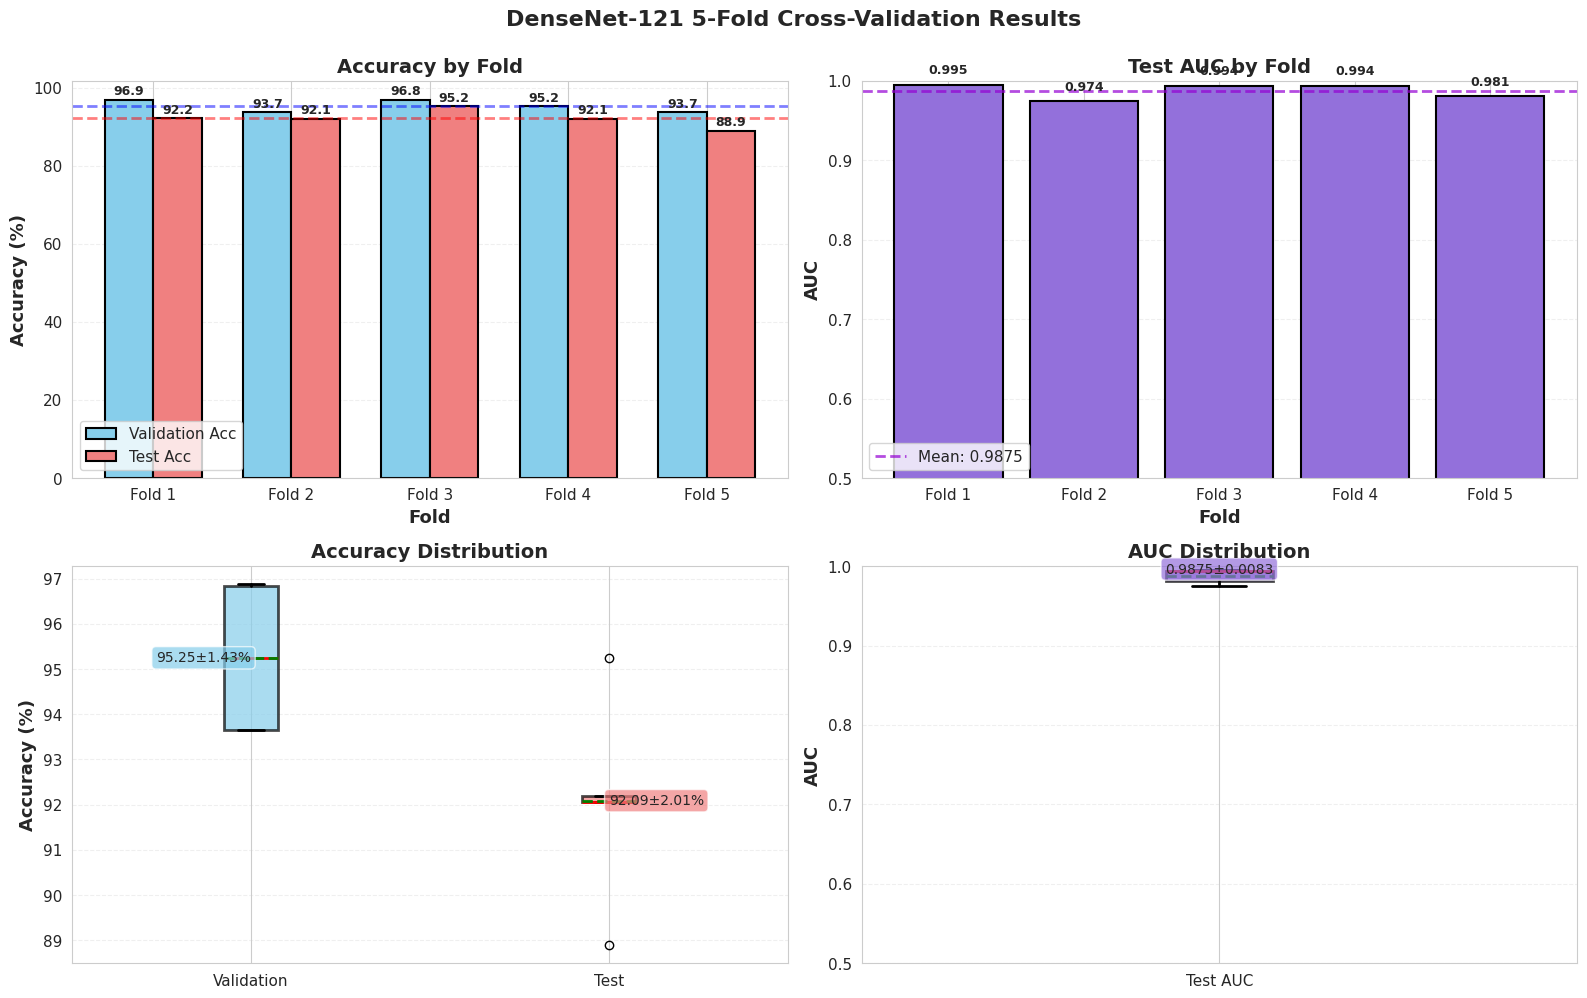

In [24]:
# ============================================================
# FINAL TEST RESULTS (with AUC)
# ============================================================

try:
    with open('kfold_results_densenet121_scratch.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    fold_nums = [f['fold'] for f in folds]
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ============================================================
    # 1. Bar chart - Accuracy
    # ============================================================
    ax = axes[0, 0]
    x = np.arange(len(fold_nums))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc',
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc',
                   color='lightcoral', edgecolor='black', linewidth=1.5)

    ax.axhline(np.mean(val_accs), color='blue', linestyle='--', alpha=0.5, linewidth=2)
    ax.axhline(np.mean(test_accs), color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy by Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i}' for i in fold_nums])
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ============================================================
    # 2. Bar chart - AUC
    # ============================================================
    ax = axes[0, 1]

    if test_aucs and len(test_aucs) > 0:
        bars = ax.bar(fold_nums[:len(test_aucs)], test_aucs,
                     color='mediumpurple', edgecolor='black', linewidth=1.5)

        mean_auc = np.mean(test_aucs)
        ax.axhline(mean_auc, color='darkviolet', linestyle='--',
                  alpha=0.7, linewidth=2, label=f'Mean: {mean_auc:.4f}')

        ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('Test AUC by Fold', fontsize=14, fontweight='bold')
        ax.set_xticks(fold_nums[:len(test_aucs)])
        ax.set_xticklabels([f'Fold {i}' for i in fold_nums[:len(test_aucs)]])
        ax.set_ylim([0.5, 1.0])
        ax.legend(fontsize=11)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    # ============================================================
    # 3. Box plots - Accuracy
    # ============================================================
    ax = axes[1, 0]
    bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
                     patch_artist=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(linewidth=2, color='red'),
                     meanprops=dict(linewidth=2, color='green'))

    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    mean_val = np.mean(val_accs)
    mean_test = np.mean(test_accs)
    std_val = np.std(val_accs)
    std_test = np.std(test_accs)

    ax.text(1, mean_val, f'{mean_val:.2f}±{std_val:.2f}%',
           ha='right', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.7))
    ax.text(2, mean_test, f'{mean_test:.2f}±{std_test:.2f}%',
           ha='left', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # ============================================================
    # 4. Box plots - AUC
    # ============================================================
    ax = axes[1, 1]

    if test_aucs and len(test_aucs) > 0:
        bp = ax.boxplot([test_aucs], labels=['Test AUC'],
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         meanprops=dict(linewidth=2, color='green'))

        bp['boxes'][0].set_facecolor('mediumpurple')
        bp['boxes'][0].set_alpha(0.7)

        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('AUC Distribution', fontsize=14, fontweight='bold')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        mean_auc = np.mean(test_aucs)
        std_auc = np.std(test_aucs)
        ax.text(1, mean_auc, f'{mean_auc:.4f}±{std_auc:.4f}',
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='mediumpurple', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.suptitle('DenseNet-121 5-Fold Cross-Validation Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('kfold_test_results_with_auc.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: kfold_test_results_with_auc.png")
    plt.show()

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_scratch.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")

/tmp/ipython-input-3703469710.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
/tmp/ipython-input-3703469710.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([test_aucs], labels=['Test AUC'],


✓ Saved: kfold_test_results_with_auc.png


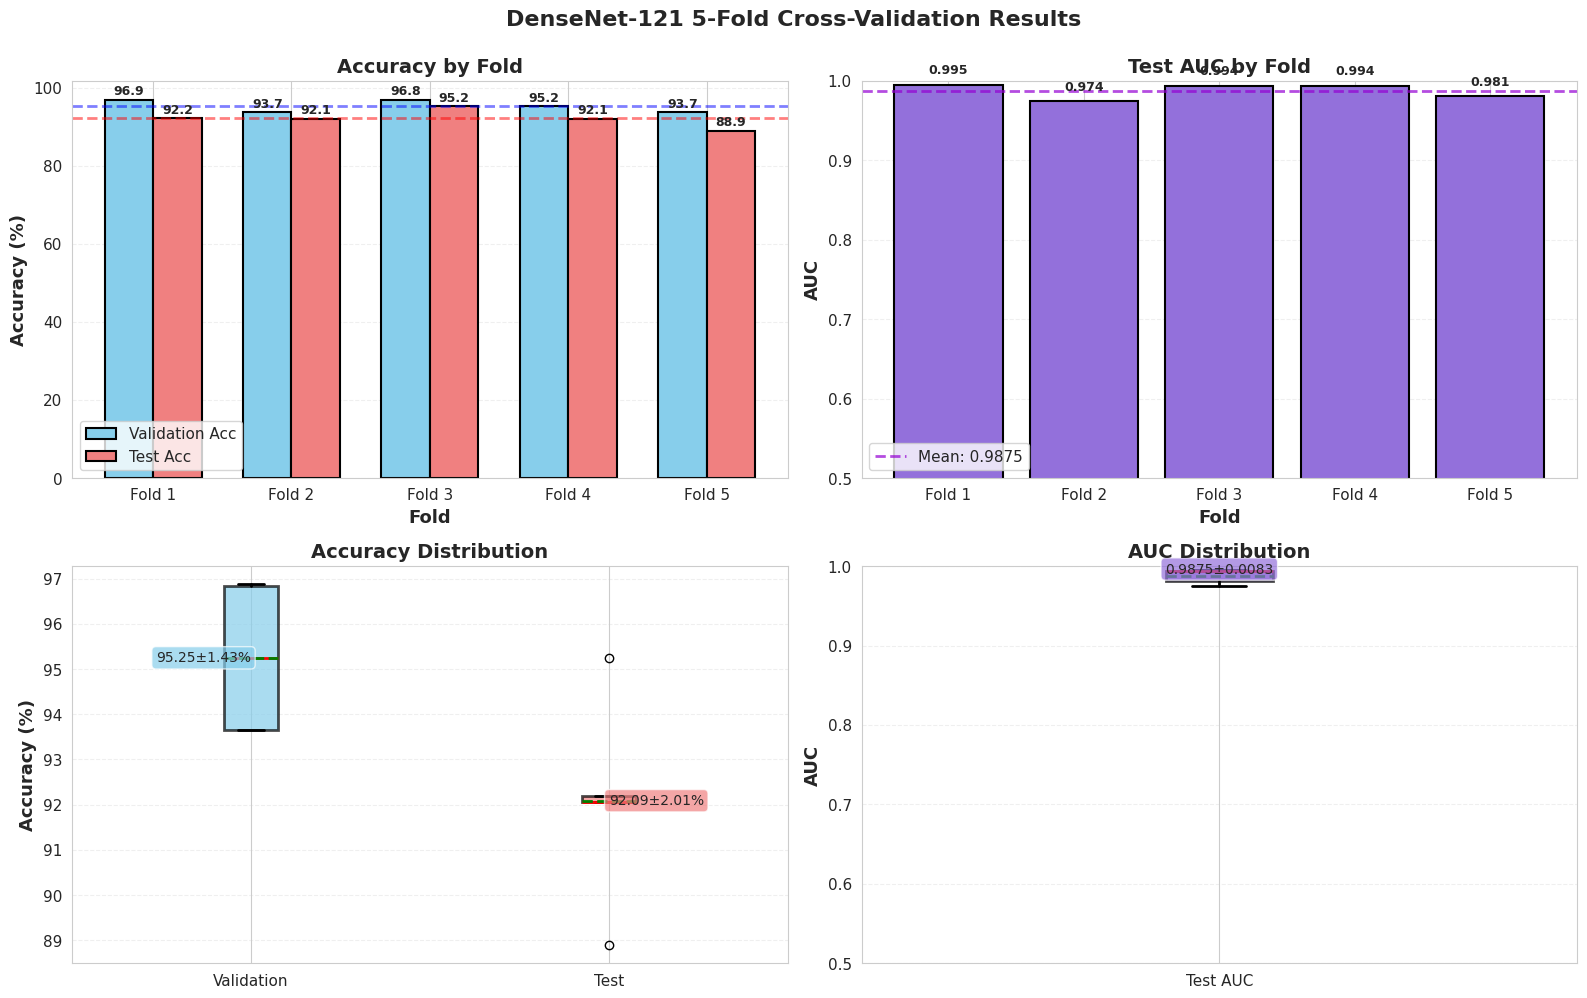

In [25]:
# ============================================================
# FINAL TEST RESULTS (with AUC)
# ============================================================

try:
    with open('kfold_results_densenet121_scratch.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    fold_nums = [f['fold'] for f in folds]
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ============================================================
    # 1. Bar chart - Accuracy
    # ============================================================
    ax = axes[0, 0]
    x = np.arange(len(fold_nums))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc',
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc',
                   color='lightcoral', edgecolor='black', linewidth=1.5)

    ax.axhline(np.mean(val_accs), color='blue', linestyle='--', alpha=0.5, linewidth=2)
    ax.axhline(np.mean(test_accs), color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy by Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i}' for i in fold_nums])
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ============================================================
    # 2. Bar chart - AUC
    # ============================================================
    ax = axes[0, 1]

    if test_aucs and len(test_aucs) > 0:
        bars = ax.bar(fold_nums[:len(test_aucs)], test_aucs,
                     color='mediumpurple', edgecolor='black', linewidth=1.5)

        mean_auc = np.mean(test_aucs)
        ax.axhline(mean_auc, color='darkviolet', linestyle='--',
                  alpha=0.7, linewidth=2, label=f'Mean: {mean_auc:.4f}')

        ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('Test AUC by Fold', fontsize=14, fontweight='bold')
        ax.set_xticks(fold_nums[:len(test_aucs)])
        ax.set_xticklabels([f'Fold {i}' for i in fold_nums[:len(test_aucs)]])
        ax.set_ylim([0.5, 1.0])
        ax.legend(fontsize=11)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    # ============================================================
    # 3. Box plots - Accuracy
    # ============================================================
    ax = axes[1, 0]
    bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
                     patch_artist=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(linewidth=2, color='red'),
                     meanprops=dict(linewidth=2, color='green'))

    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    mean_val = np.mean(val_accs)
    mean_test = np.mean(test_accs)
    std_val = np.std(val_accs)
    std_test = np.std(test_accs)

    ax.text(1, mean_val, f'{mean_val:.2f}±{std_val:.2f}%',
           ha='right', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.7))
    ax.text(2, mean_test, f'{mean_test:.2f}±{std_test:.2f}%',
           ha='left', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # ============================================================
    # 4. Box plots - AUC
    # ============================================================
    ax = axes[1, 1]

    if test_aucs and len(test_aucs) > 0:
        bp = ax.boxplot([test_aucs], labels=['Test AUC'],
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         meanprops=dict(linewidth=2, color='green'))

        bp['boxes'][0].set_facecolor('mediumpurple')
        bp['boxes'][0].set_alpha(0.7)

        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('AUC Distribution', fontsize=14, fontweight='bold')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        mean_auc = np.mean(test_aucs)
        std_auc = np.std(test_aucs)
        ax.text(1, mean_auc, f'{mean_auc:.4f}±{std_auc:.4f}',
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='mediumpurple', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.suptitle('DenseNet-121 5-Fold Cross-Validation Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('kfold_test_results_with_auc.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: kfold_test_results_with_auc.png")
    plt.show()

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_scratch.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")

In [26]:
# ============================================================
# PRINT FINAL SUMMARY STATISTICS
# ============================================================

try:
    with open('kfold_results_densenet121_scratch.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    print("\n" + "="*70)
    print(" "*20 + "CROSS-VALIDATION RESULTS")
    print("="*70)
    print(f"\nNumber of Folds: {len(folds)}")

    print("\n" + "-"*70)
    print("VALIDATION ACCURACY:")
    print("-"*70)
    print(f"  Mean:  {np.mean(val_accs):.2f}%")
    print(f"  Std:   ±{np.std(val_accs):.2f}%")
    print(f"  Range: [{min(val_accs):.2f}%, {max(val_accs):.2f}%]")

    print("\n" + "-"*70)
    print("TEST ACCURACY:")
    print("-"*70)
    print(f"  Mean:  {np.mean(test_accs):.2f}%")
    print(f"  Std:   ±{np.std(test_accs):.2f}%")
    print(f"  Range: [{min(test_accs):.2f}%, {max(test_accs):.2f}%]")

    if test_aucs and len(test_aucs) > 0:
        print("\n" + "-"*70)
        print("TEST AUC:")
        print("-"*70)
        print(f"  Mean:  {np.mean(test_aucs):.4f}")
        print(f"  Std:   ±{np.std(test_aucs):.4f}")
        print(f"  Range: [{min(test_aucs):.4f}, {max(test_aucs):.4f}]")

    print("\n" + "-"*70)
    print("BEST FOLD:")
    print("-"*70)
    best_fold_idx = np.argmax(test_accs)
    print(f"  Fold {folds[best_fold_idx]['fold']}")
    print(f"  Test Accuracy: {max(test_accs):.2f}%")
    if test_aucs and len(test_aucs) > 0:
        print(f"  Test AUC: {test_aucs[best_fold_idx]:.4f}")

    print("\n" + "-"*70)
    print("WORST FOLD:")
    print("-"*70)
    worst_fold_idx = np.argmin(test_accs)
    print(f"  Fold {folds[worst_fold_idx]['fold']}")
    print(f"  Test Accuracy: {min(test_accs):.2f}%")
    if test_aucs and len(test_aucs) > 0:
        print(f"  Test AUC: {test_aucs[worst_fold_idx]:.4f}")

    print("\n" + "="*70)
    print("✅ Analysis complete!")
    print("="*70 + "\n")

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_scratch.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")


                    CROSS-VALIDATION RESULTS

Number of Folds: 5

----------------------------------------------------------------------
VALIDATION ACCURACY:
----------------------------------------------------------------------
  Mean:  95.25%
  Std:   ±1.43%
  Range: [93.65%, 96.88%]

----------------------------------------------------------------------
TEST ACCURACY:
----------------------------------------------------------------------
  Mean:  92.09%
  Std:   ±2.01%
  Range: [88.89%, 95.24%]

----------------------------------------------------------------------
TEST AUC:
----------------------------------------------------------------------
  Mean:  0.9875
  Std:   ±0.0083
  Range: [0.9744, 0.9950]

----------------------------------------------------------------------
BEST FOLD:
----------------------------------------------------------------------
  Fold 3
  Test Accuracy: 95.24%
  Test AUC: 0.9936

----------------------------------------------------------------------
WORST 